# Fitting a Decomposed Model

In [13]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime
import os
from glob import glob

# ARIMA
from pmdarima.pipeline import Pipeline
from pmdarima import ARIMA

import statsmodels.api as sm

# My stuff
from base_config import BaseConfig
from handler import *

import matplotlib
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(ticks=True, grid=True, gridlines='--')

from scipy.stats import boxcox
from scipy.special import inv_boxcox

### Global Parameters and Dataset Prep

In [14]:
print('Available Metrics:\n')
for metric in [x[7:-4] for x in glob('./data/*.csv')]:
    print(metric)

Available Metrics:

Global_reactive_power
Sub_metering_2
Sub_metering_3
Sub_metering_1
Voltage
Global_intensity
Global_active_power


In [15]:
metric = 'Global_intensity'

In [16]:
cfg = BaseConfig(
    dataPath='./data',
    outPath='./out',
    runId='TEST',
    metric=metric,
    minDateData=None,
    maxDateData=None,
    numDaysPred=365,
)

In [17]:
#cfg.dataset.loc[:, metric].plot() # Need to patch these days

In [18]:
if metric == 'Global_active_power' or metric == 'Global_intensity':
    cfg.patchSeries('2008-08-13', '2008-08-30')

In [19]:
dataset = cfg.dataset

In [20]:
firstDayTrain = '2006-12-16'
firstDayPred = '2010-12-12'

### Original Time Series

In [21]:
dataset['RollingMetric'] = dataset[metric].rolling(7, center=True).mean()

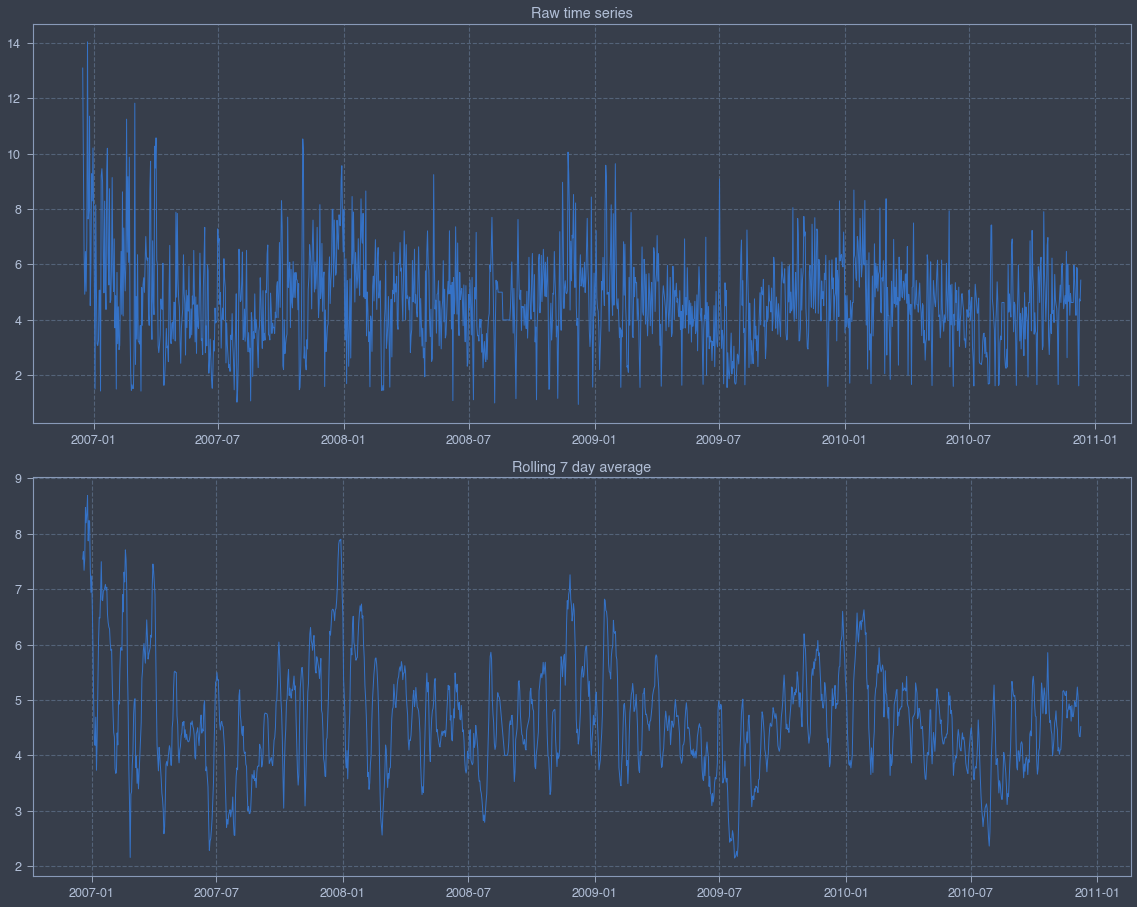

In [22]:
f, axes = plt.subplots(2, 1, figsize=(16, 12.8))
axes[0].plot(dataset.index, dataset[metric], linewidth=1)
axes[0].set_title('Raw time series')
axes[1].plot(dataset.index, dataset['RollingMetric'], linewidth=1)
axes[1].set_title('Rolling 7 day average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Box-Cox Transformation

In [23]:
X_rolling = dataset['RollingMetric'].loc[firstDayTrain:].dropna()
X = dataset[metric].loc[firstDayTrain:].dropna()

In [24]:
automatic = True
if not automatic:
    optimal_lmda = 1
    X_rolling_transformed = boxcox(X_rolling+1, lmbda=optimal_lmda)
    X_transformed = boxcox(X+1, lmbda=optimal_lmda)
else:
    X_rolling_transformed, optimal_lmda = boxcox(X_rolling+1)
    X_transformed = boxcox(X+1, lmbda=optimal_lmda)
    print("Initial optimal lambda: ", optimal_lmda)
    if optimal_lmda <= 0 or optimal_lmda > 1:
        raise RuntimeError("Optimal lambda outside of acceptable range.  Please set manually")

Initial optimal lambda:  0.12203605878336708


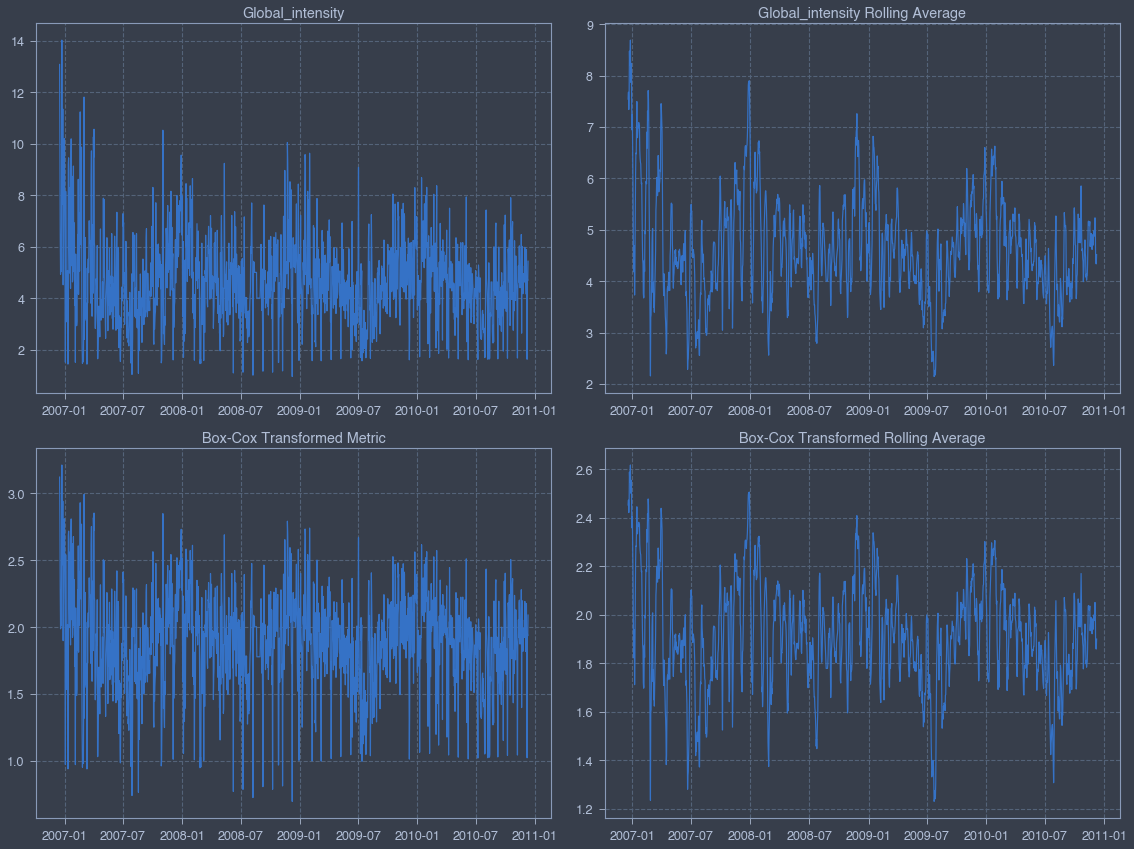

In [26]:
f, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].plot(X)
axes[0, 0].set_title(metric)
axes[0, 1].plot(X_rolling)
axes[0, 1].set_title(metric + ' Rolling Average')
#axes[0, 0].grid(linestyle='dashed')
#axes[0, 1].grid(linestyle='dashed')
axes[1, 0].plot(X.index, X_transformed)
axes[1, 0].set_title('Box-Cox Transformed Metric')
axes[1, 1].plot(X_rolling.index, X_rolling_transformed)
axes[1, 1].set_title('Box-Cox Transformed Rolling Average')
#axes[1, 0].grid(linestyle='dashed')
#axes[1, 1].grid(linestyle='dashed')
plt.tight_layout()

In [27]:
dataset['BoxCoxTransformedMetric'] = pd.Series(X_transformed, index=X.index)
dataset['BoxCoxTransformedRolling'] = pd.Series(X_rolling_transformed, index=X_rolling.index)

## Fit Global Trend

In [28]:
Y = dataset['RollingMetric'].loc[firstDayTrain:].dropna()

In [29]:
X = np.arange(0, Y.shape[0])

In [30]:
power = 1.0 # This should never be zero.
XPow = X**power
globalSlope, globalIntercept = np.polyfit(XPow, Y, deg = 1)
G = globalSlope*XPow + globalIntercept

In [31]:
df = pd.DataFrame({
    'x_pow' : XPow,
    'intercept' : 1
})

In [32]:
linear_model = sm.OLS(Y.values, df)
statsLR=linear_model.fit()
print(statsLR.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.026    
Dependent Variable: y                AIC:                4090.9223
Date:               2021-02-01 22:31 BIC:                4101.4823
No. Observations:   1451             Log-Likelihood:     -2043.5  
Df Model:           1                F-statistic:        39.74    
Df Residuals:       1449             Prob (F-statistic): 3.84e-10 
R-squared:          0.027            Scale:              0.98032  
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
x_pow          -0.0004    0.0001  -6.3040  0.0000  -0.0005  -0.0003
intercept       4.9486    0.0520  95.2409  0.0000   4.8467   5.0505
------------------------------------------------------------------
Omnibus:               43.498       Durbin-Watson:          0.102 
Prob(Omn

Text(0.5, 1.0, 'Series vs OLS')

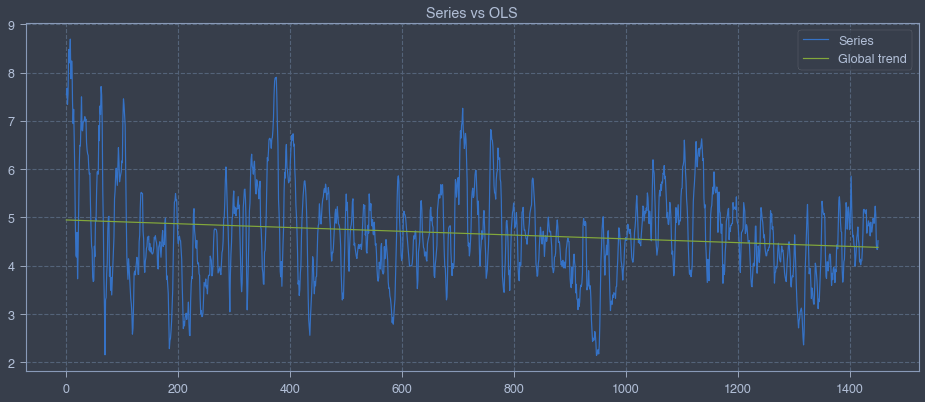

In [33]:
plt.figure(figsize=(16, 6.4))
plt.plot(Y.values, label='Series')
plt.plot(G, label='Global trend')
plt.legend()
#plt.grid(linestyle='dashed')
plt.title('Series vs OLS')

Skipping negative slope for 0-degree 'best fit'.


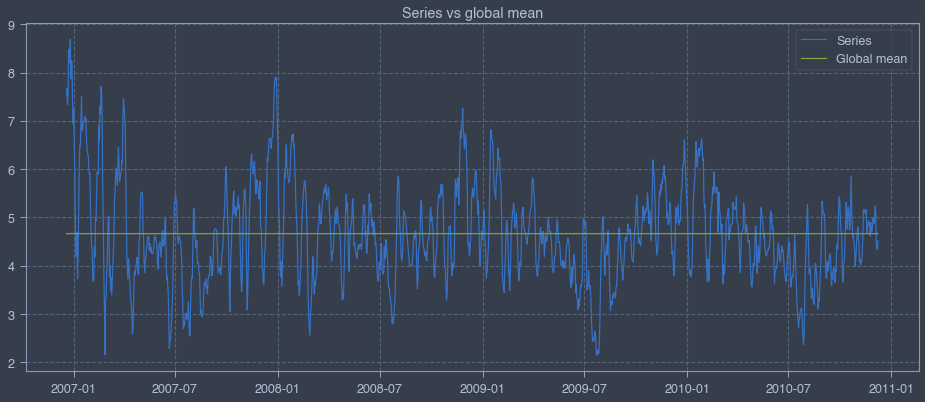

In [34]:
skipOLS = True
if skipOLS:
    print('Skipping negative slope for 0-degree \'best fit\'.')
    fitLinearTrend = pd.Series(Y.mean(), index=Y.index)
    plt.figure(figsize=(16, 6.4))
    plt.plot(Y, label='Series')
    plt.plot(fitLinearTrend, label='Global mean')
    plt.legend()
    #plt.grid(linestyle='dashed')
    plt.title('Series vs global mean')
else:
    fitLinearTrend = pd.Series(G, index=Y.index)

In [35]:
def extrapolateGlobalTrendLinear(numDaysPredict, startDate):
    r""" extrapolate the global trend by `numDaysPredict` days. """

    # Use this value to calculate amount to translate before fitting.
    minDate = fitLinearTrend.index.min()
    xTranslate = (startDate - minDate).days
    X = np.arange(xTranslate, xTranslate + numDaysPredict)

    Xpow = X**power
    globalTrend = globalSlope*Xpow + globalIntercept

    idx = cfg._getDateIndex(minDate=startDate, maxDate=startDate+relativedelta(days=numDaysPredict-1))
    return pd.Series(globalTrend, index=idx)

In [36]:
preExtrapolate = extrapolateGlobalTrendLinear(3, dataset.index.min())
postExtrapolate = extrapolateGlobalTrendLinear(3, fitLinearTrend.index.max()+relativedelta(days=1))

In [37]:
dataset['GlobalTrend'] = pd.concat([preExtrapolate, fitLinearTrend, postExtrapolate])

In [38]:
dataset['DetrendedMetric'] = dataset['BoxCoxTransformedMetric'] - dataset['GlobalTrend']
dataset['DetrendedRolling'] = dataset['BoxCoxTransformedRolling'] - dataset['GlobalTrend']

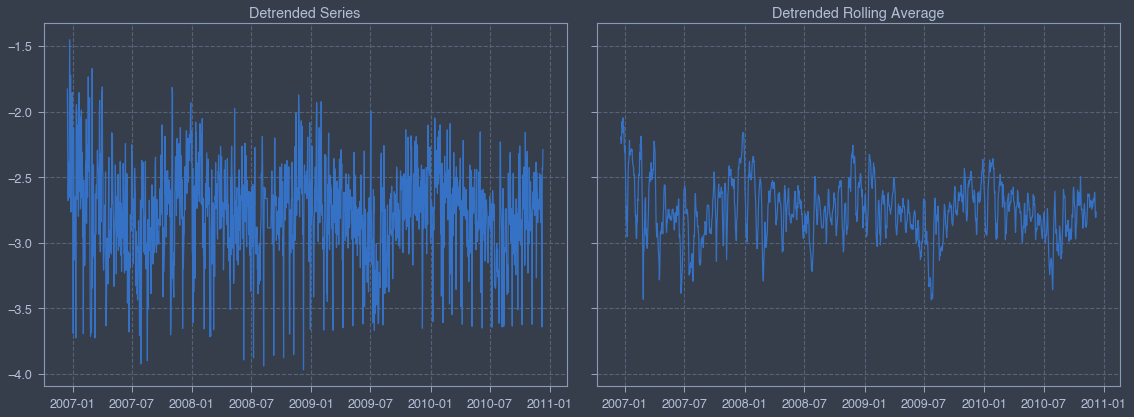

In [39]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset['DetrendedMetric'].loc[firstDayTrain:].dropna())
axes[0].set_title('Detrended Series')
axes[1].plot(dataset['DetrendedRolling'].loc[firstDayTrain:].dropna())
axes[1].set_title('Detrended Rolling Average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

## Fit Fourier Decomposition

In [40]:
y = dataset['DetrendedRolling'].loc[firstDayTrain:].dropna().loc['2009-01-01' : '2009-12-31']
x = y.index
xs = range(len(y))
z = y # already subtracted best fit

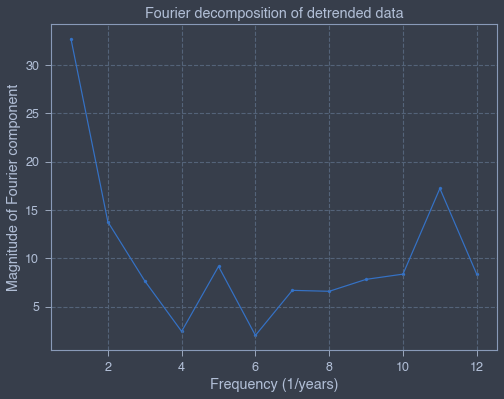

In [41]:
Z = np.fft.fft(z)
plt.figure(figsize=(8,6))
plt.plot(range(1, 13), np.abs(Z[1:13]))
plt.scatter(range(1, 13), np.abs(Z[1:13]), s=10)
plt.xlabel('Frequency (1/years)')
plt.ylabel('Magnitude of Fourier component')
#plt.grid()
_=plt.title('Fourier decomposition of detrended data')

In [42]:
def top_component_filter(Z, i, threshold=12):
    Z_filtered = Z.copy() # necessary to copy?  I don't want any side effects
    
    # kill high frequency components to avoid weekly seasonality dominating
    Z_filtered[range(threshold+1, len(Z_filtered))] = 0
    
    if i > 0:
        # This breaks for i==0, so need the condition
        inds = np.abs(Z_filtered).argsort()[:-i] # indices of all but top i weighted components
        Z_filtered[inds] = 0
    else:
        Z_filtered = np.zeros(Z.shape)
    
    return Z_filtered

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


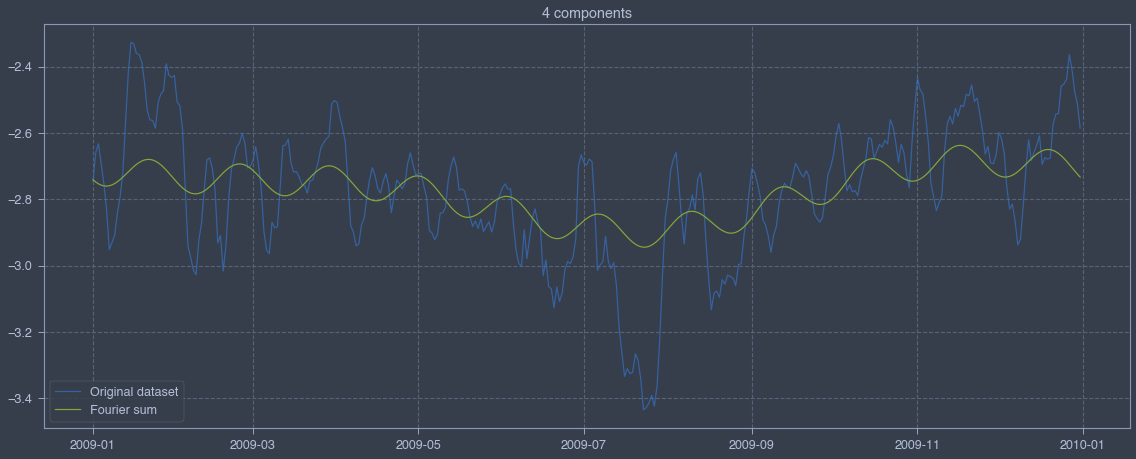

In [43]:
f, ax = plt.subplots(figsize=(16, 6.4))
plt.tight_layout()
num_components = 4
Z = np.fft.fft(z)
Z_filtered1 = top_component_filter(Z, num_components, threshold=12)
ifft1 = np.fft.ifft(Z_filtered1)
ax.plot(x, z, alpha=0.7, label="Original dataset")
ax.plot(x, ifft1, alpha=1, label='Fourier sum')
ax.set_title(str(num_components)+' components')
#ax.grid(linestyle='dashed')
ax.legend()

In [44]:
Z = np.fft.fft(z)
Z_filtered1 = top_component_filter(Z, 3, threshold=12)
ifft1 = np.fft.ifft(Z_filtered1)

In [45]:
df = pd.DataFrame(data={'FourierSum' : ifft1.real}, index=x)

In [46]:
def dateTimeToMonthDay(datetime_index):
    return datetime_index.map(lambda x: x.strftime('%m-%d'))

In [47]:
dataset['tmpMonthDay'] = dateTimeToMonthDay(dataset.index)

In [48]:
df['tmpMonthDay'] = dateTimeToMonthDay(df.index)

In [49]:
dataset = (dataset
           .reset_index()
           .merge(df,
                  left_on='tmpMonthDay',
                  right_on='tmpMonthDay',
                  how='left')
           .set_index('Date')
           .drop('tmpMonthDay', axis=1))

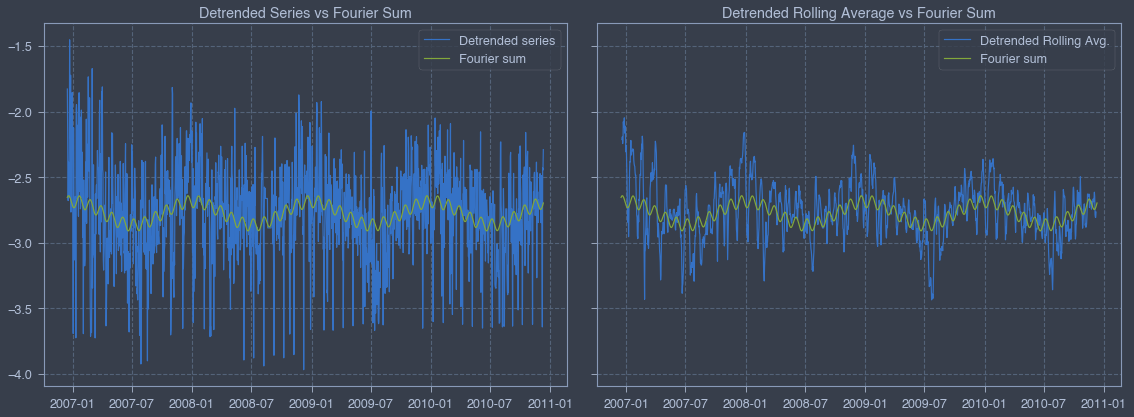

In [50]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'DetrendedMetric'],
             label='Detrended series')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'FourierSum'],
             label='Fourier sum')
axes[0].legend()
axes[0].set_title('Detrended Series vs Fourier Sum')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'DetrendedRolling'],
             label='Detrended Rolling Avg.')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'FourierSum'],
             label='Fourier sum')
axes[1].legend()
axes[1].set_title('Detrended Rolling Average vs Fourier Sum')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

In [51]:
dataset['NonSeasonal'] = dataset['DetrendedMetric'] - dataset['FourierSum']
dataset['NonSeasonalRolling'] = dataset['DetrendedRolling'] - dataset['FourierSum']

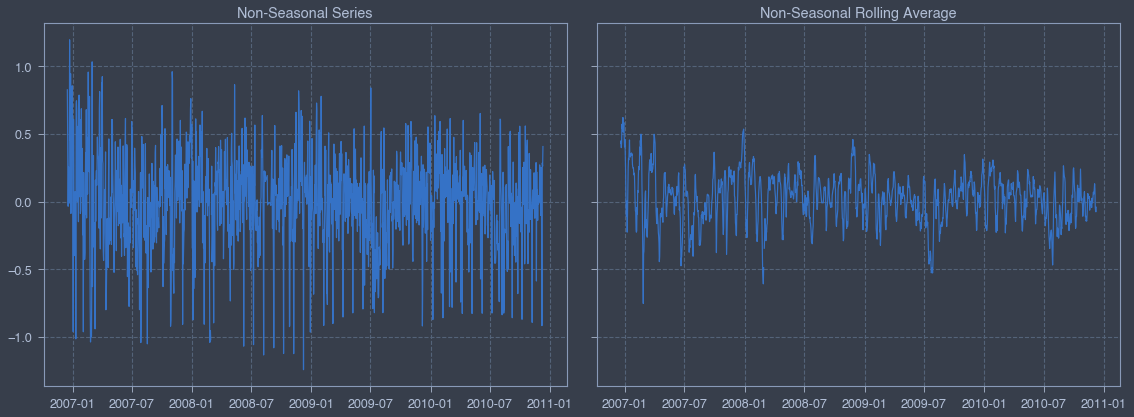

In [52]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharey='row')
axes[0].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'NonSeasonal'])
axes[0].set_title('Non-Seasonal Series')
axes[1].plot(dataset.loc[firstDayTrain:].index,
             dataset.loc[firstDayTrain:, 'NonSeasonalRolling'])
axes[1].set_title('Non-Seasonal Rolling Average')
#axes[0].grid(linestyle='dashed')
#axes[1].grid(linestyle='dashed')
plt.tight_layout()

In [55]:
#dataset.loc['2008-10', 'NonSeasonal'].plot()

## Fitting an ARIMA on Non-Seasonal Series

In [56]:
model = ARIMA(
    order=(2, 0, 1),
    seasonal_order=(1, 1, 1, 30), # Not strong enough evidence of a weekly pattern.
    with_intercept=False,
    trend=None
)

In [57]:
model.fit(dataset.loc[firstDayTrain:, 'NonSeasonal'])

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(order=(2, 0, 1), seasonal_order=(1, 1, 1, 30), with_intercept=False)

### In-sample

In [58]:
inSamplePreds = model.predict_in_sample()

In [59]:
dataset.loc[firstDayTrain:, 'ArimaInSamplePred'] = inSamplePreds

Text(0.5, 1.0, 'Observed vs. In-Sample Preds')

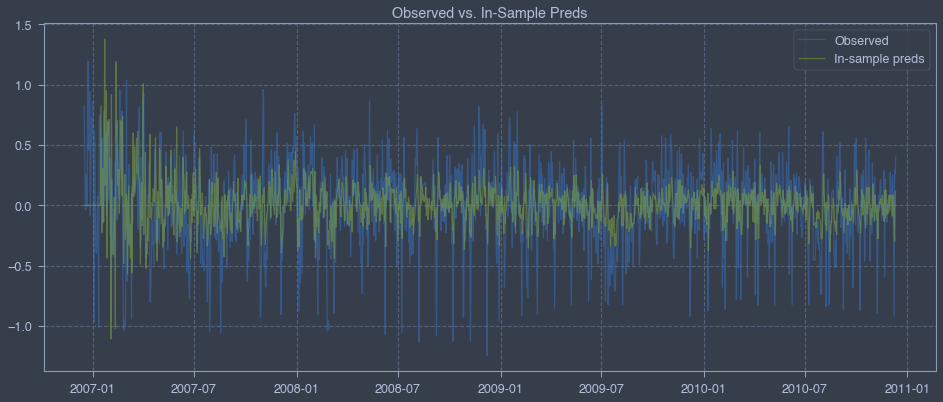

In [60]:
plt.figure(figsize=(16,6.4))
plt.plot(dataset.index, dataset['NonSeasonal'], alpha=0.5, label='Observed')
plt.plot(dataset.index, dataset['ArimaInSamplePred'], alpha=0.5, label='In-sample preds')
plt.legend()
#plt.grid(linestyle='dashed')
plt.title('Observed vs. In-Sample Preds')

### Out-of-sample

In [61]:
begin = cfg.lastObservedDate + relativedelta(days=1)
end = cfg.lastObservedDate + relativedelta(days=366)

In [62]:
outOfSamplePreds, predCIs = model.predict(
    n_periods=365,
    return_conf_int=True,
    alpha=0.2)

In [63]:
df = pd.DataFrame(
    data={
        'ArimaOutOfSamplePred' : outOfSamplePreds,
        '80%ConfIntLower' : predCIs[:, 0],
        '80%ConfIntUpper' : predCIs[:, 1]
    },
    index=pd.date_range(begin, end + relativedelta(days=-1), name='Date')
)

In [64]:
dataset = dataset.join(df, how='outer')

(<Figure size 1152x460.8 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Transformed Detrended Non-Seasonal Series'}, xlabel='Date', ylabel='NonSeasonal'>)

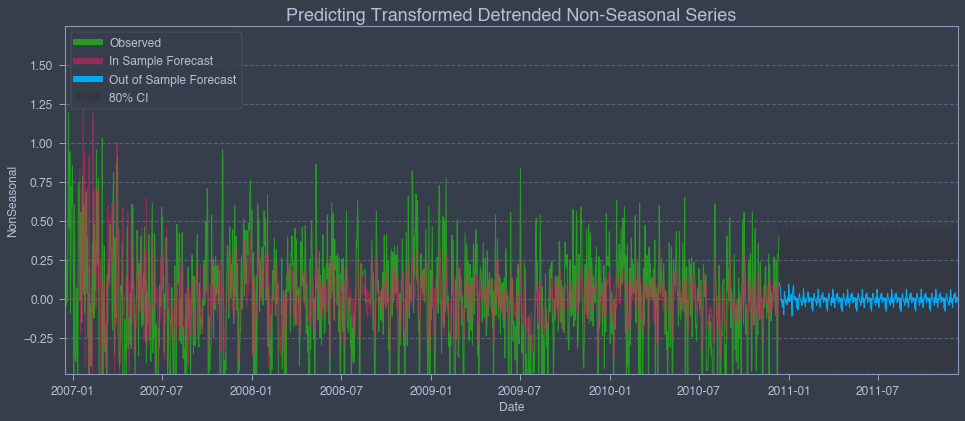

In [65]:
plotForecast(
    dataset,
    metric='NonSeasonal',
    inSamplePredCol='ArimaInSamplePred',
    ooSamplePredCol='ArimaOutOfSamplePred',
    ciLowerCol='80%ConfIntLower',
    ciUpperCol='80%ConfIntUpper',
    figSize=(16, 6.4),
    fontSize=12,
    lineWidth=1,
    #xRange=(pd.to_datetime('2010-07-01'), pd.to_datetime('2011-07-01')),
    #yRange=(-1, 1),
    titleText='Predicting Transformed Detrended Non-Seasonal Series'
)

## Back-Transformed Predictions

### Extrapolate Global and Seasonal Trends

In [66]:
firstExtrapolateDay = pd.to_datetime(firstDayPred)

In [67]:
se = pd.Series(
    extrapolateGlobalTrendLinear(365, firstExtrapolateDay),
    index = dataset.loc[firstDayPred:].index
)
dataset['GlobalTrend'] = pd.concat([dataset['GlobalTrend'].dropna(), se])

In [68]:
fourierDf = dataset.loc['2009-01-01' : '2009-12-31', ['FourierSum']]
fourierDf['tmpMonthDay'] = dateTimeToMonthDay(fourierDf.index)

In [69]:
dataset['tmpMonthDay'] = dateTimeToMonthDay(dataset.index)
dataset = (dataset
           .reset_index()
           .drop(['FourierSum'], axis=1)
           .merge(fourierDf,
                  left_on='tmpMonthDay',
                  right_on='tmpMonthDay',
                  how='left')
           .set_index('Date')
           .drop('tmpMonthDay', axis=1))

### Before Inverse Box-Cox

In [70]:
dataset['ArimaInSampleWithTrend'] = dataset['ArimaInSamplePred'] + dataset['GlobalTrend'] + dataset['FourierSum']
dataset['ArimaOoSampleWithTrend'] = dataset['ArimaOutOfSamplePred'] + dataset['GlobalTrend'] + dataset['FourierSum']
dataset['80%ConfIntLowerWTrend'] = dataset['80%ConfIntLower'] + dataset['GlobalTrend'] + dataset['FourierSum']
dataset['80%ConfIntUpperWTrend'] = dataset['80%ConfIntUpper'] + dataset['GlobalTrend'] + dataset['FourierSum']

(<Figure size 1152x460.8 with 1 Axes>,
 <AxesSubplot:title={'center':'Predicting Box-Cox Transformed Series'}, xlabel='Date', ylabel='BoxCoxTransformedMetric'>)

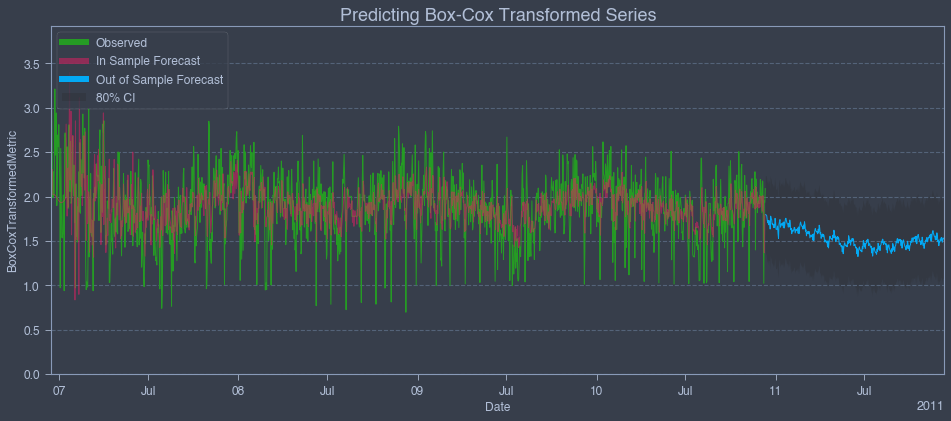

In [72]:
plotForecast(
    dataset,
    metric='BoxCoxTransformedMetric',
    inSamplePredCol='ArimaInSampleWithTrend',
    ooSamplePredCol='ArimaOoSampleWithTrend',
    ciLowerCol='80%ConfIntLowerWTrend',
    ciUpperCol='80%ConfIntUpperWTrend',
    figSize=(16, 6.4),
    fontSize=12,
    lineWidth=1,
    #xRange=(pd.to_datetime('2019-06-01'), pd.to_datetime('2020-06-01')),
    #yRange=(230, 255),
    titleText='Predicting Box-Cox Transformed Series'
)

### After Inverse Box-Cox

In [73]:
def inverse_boxcox(se):
    return pd.Series(inv_boxcox(se.values, optimal_lmda) - 1, index=se.index)

In [74]:
dataset['ArimaInvBcInSample'] = inverse_boxcox(dataset['ArimaInSampleWithTrend'])
dataset['ArimaInvBcOoSample'] = inverse_boxcox(dataset['ArimaOoSampleWithTrend'])
dataset['80%ConfIntLowerWTrendBc'] = inverse_boxcox(dataset['80%ConfIntLowerWTrend'])
dataset['80%ConfIntUpperWTrendBc'] = inverse_boxcox(dataset['80%ConfIntUpperWTrend'])

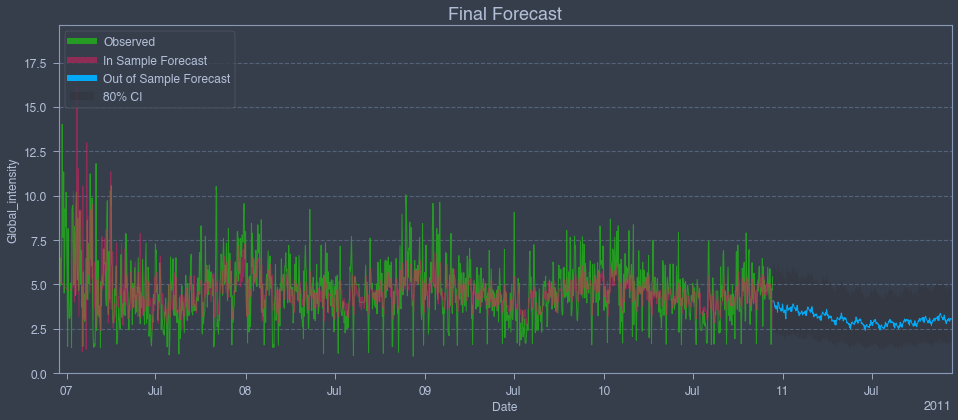

In [76]:
f, ax = plotForecast(
    dataset,
    metric=metric,
    inSamplePredCol='ArimaInvBcInSample',
    ooSamplePredCol='ArimaInvBcOoSample',
    ciLowerCol='80%ConfIntLowerWTrendBc',
    ciUpperCol='80%ConfIntUpperWTrendBc',
    figSize=(16, 6.4),
    fontSize=12,
    lineWidth=1,
    #xRange=(pd.to_datetime('2019-06-01'), pd.to_datetime('2020-06-01')),
    #yRange=(230, 255),
    titleText='Final Forecast'
)
plt.savefig('./out/3_16_'+metric+'_forecast.png')